In [1]:
import csv
import pandas as pd
import numpy as np
import operator
import xgboost
from xgboost import XGBRegressor 
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

First of all we import the two datasets we are going to work on.

In [2]:
train = pd.read_csv(r'all\train.csv', sep = ',')
test = pd.read_csv(r'all\test.csv', sep = ',')

## Data cleaning

#### Dealing with the bias

First of all we decide to shrink the range of SalePrice (in the *train* dataset) in order to reduce the bias of the fit function. These are the best values that we found out empirically for our model.

In [3]:
train.loc[(train.SalePrice < 38000), 'SalePrice'] = train.SalePrice + 8000
train.loc[(train.SalePrice > 620000), 'SalePrice'] = train.SalePrice - 27000

#### Removing the outliers

In order to find the ouliers we show a visualization of correlation between each numerical feature and *SalePrice*.

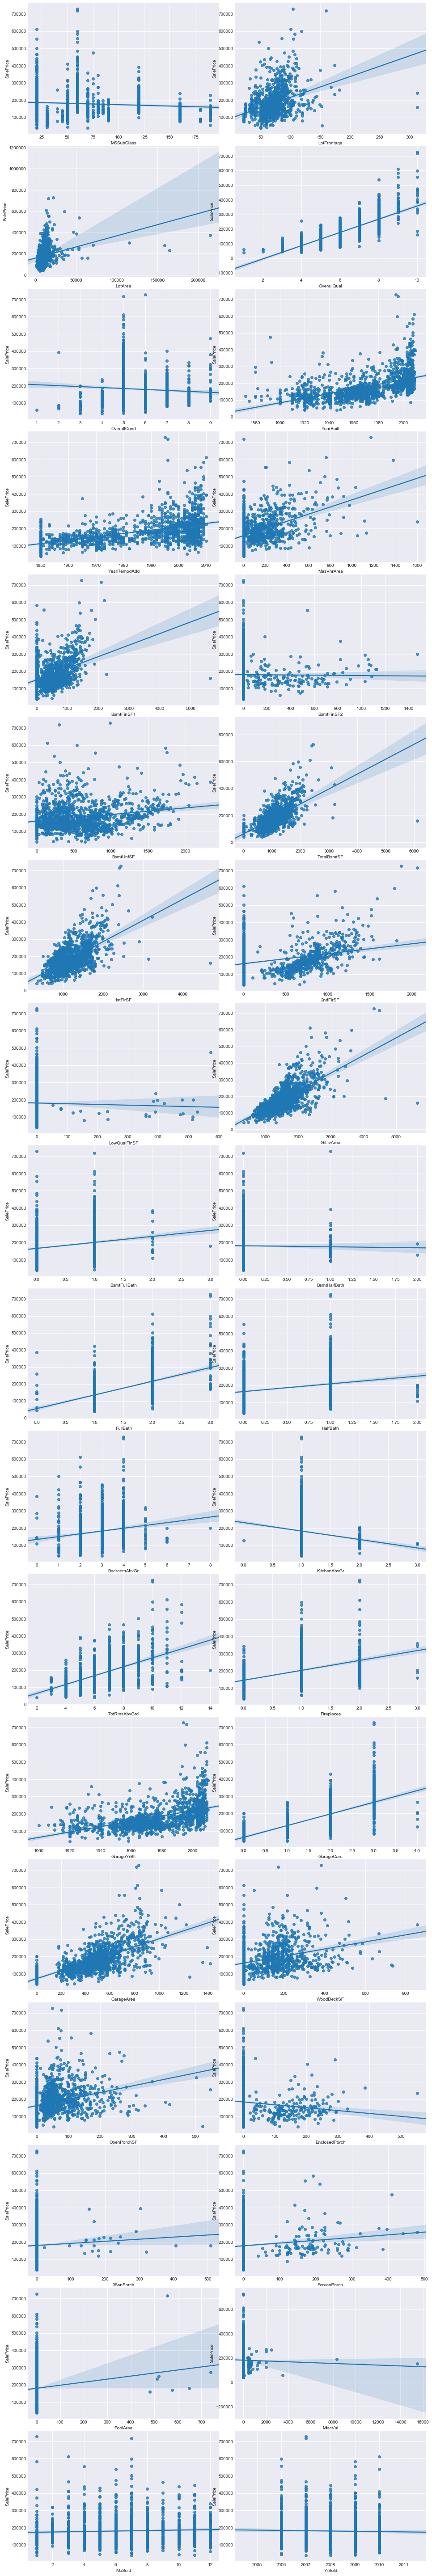

In [4]:
# searching the ouliers 
fig, ax = plt.subplots(18, 2, 'row', figsize = (13, 80))
plt.tight_layout()
i = 1
for feature in train.columns:
    if feature != 'Id' and feature != 'SalePrice':
        if train[feature].dtype == 'int64' or train[feature].dtype == 'float64':
            plt.subplot(18, 2, i)
            sns.regplot(x = train[feature], y = train['SalePrice'])
            plt.xlabel(feature)
            i += 1

As we can see there six houses that have a large *LotArea* (we can suppose that they are actually agricultural land). Since they are exceptions, we can drop them. There is also one house that have a large *GrLivArea* and a corresponding low *SalePrice* and another house that has a high value for *LotFrontage* and again low *SalePrice*. 

In [5]:
train = train.drop(train[train.LotArea > 60000].index)
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 200000)].index)
train = train.drop(train[(train.LotFrontage > 300) & (train.SalePrice < 300000)].index)

#### Features transformation 

We noticed that actually *MSSubClass* is a categorical feature: its values are numerical codes so we can treat them as string.

In [6]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)

We decided to merge some features because individually they didn't not represent any useful informations for our model.

In [7]:
train['TotFlrSF'] = train['1stFlrSF'] + train['2ndFlrSF']
test['TotFlrSF'] = test['1stFlrSF'] + test['2ndFlrSF']
train['TotBsmtBath'] = train['BsmtFullBath'] + train['BsmtHalfBath']
test['TotBsmtBath'] = test['BsmtFullBath'] + test['BsmtHalfBath']
# the old features will be dropped

#### Dealing with NaN values

Now we can deal with *NaN* values: we create a list of features sorted by the number of *NaN* values they have (in descending order).

In [8]:
# nan_dict = {feature : number_nan_values}
nan_dict = {}
for col in test:
    nan_count = test[test[col].isna()]
    if len(nan_count) > 0:
        nan_dict[col] = len(nan_count)

sorted_nan = sorted(nan_dict.items(), key = operator.itemgetter(1))
# list sorted in descending order of nan values       
sorted_nan.reverse()

Here we distinguish two differente ways to deal with *NaN*, i.e. which features will be imputed with constant values (*zero* and *None*).

In [9]:
# list of numerical features whose nan values will be replaced with a constant value (in this case 0) 
numerical_feature_nan_to_zero = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars'] 
# list of categorical features whose nan values will be replaced with a constant value (in this case None) 
string_feature_nan_to_none = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageCond', 
                                'GarageType', 'MasVnrType']

#### Dropping the features

The heat map shows us the correlation between the features: it's useful to see if there are features that are strongly correlated with others or that are weakly correlated with *SalePrice*.

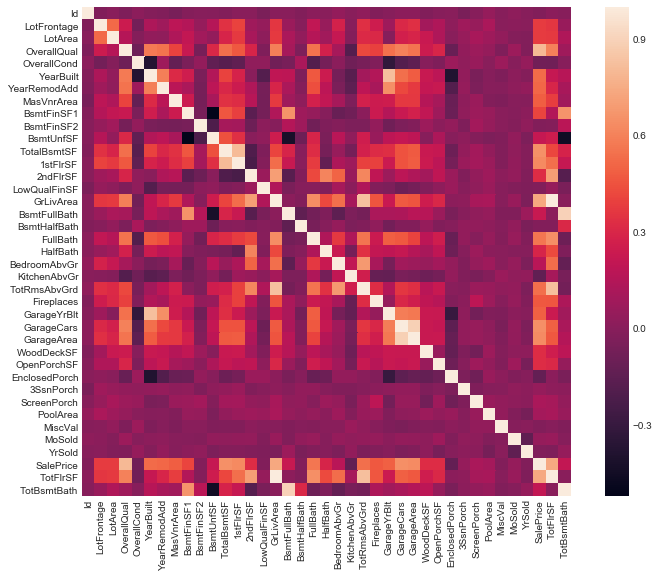

In [10]:
# heat map of correlation matrix
corr = train.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corr, vmax = 1, square = True);

Thus first of all we can drop the features that have a number on *NaN* greater than 200 and then those who are not significant, strongly correlated with certain others, weakly correlated with *SalePrice*.

In [11]:
drop_col = [tup[0] for tup in sorted_nan[:6]]

# total list of features to drop
to_drop = drop_col + ['Id', 'Utilities', 'Condition2', 'TotRmsAbvGrd', 'Functional', 
                      'GarageArea', 'WoodDeckSF', 'RoofMatl', 'TotalBsmtSF',
                      'GarageFinish', '1stFlrSF', '2ndFlrSF', 'MasVnrArea',
                      'BsmtFullBath', 'BsmtHalfBath', 'MSZoning', 'KitchenQual',
                      'LandContour', 'LotConfig', 'LandSlope', 'RoofStyle', 
                      'RoofMatl','Exterior1st', 'Exterior2nd', 'Foundation', 
                      'BsmtQual', 'BsmtCond', 'Electrical', 'GarageQual'] 

dropped_test = test.drop(to_drop, axis = 1)
dropped_train = train.drop(to_drop, axis = 1)

In [12]:
# distinguishing categorical and numeric features
str_feature = [i for i in dropped_test.columns if isinstance(dropped_test[i][0], str)]
num_feature = [i for i in (set(dropped_test.columns).difference(str_feature))]

In [13]:
# distinguishing the categorical features from ones that have nan values to be replaced with the None value 
str_featureSet = set(str_feature)
str_featureSet -= set(string_feature_nan_to_none)

str_feature = list(str_featureSet)

Knowing that the target variable is skewed we can convert the *SalePrice* into its *log* in order to have a variable which is (more) normally distributed. After this, we build the Pipeline for our model.

In [14]:
# make copy to avoid changing original data (when Imputing)
new_test = dropped_test.copy()
new_train = dropped_train.copy()
reduced_train = new_train.drop('SalePrice', axis = 1)

# the target variable is skewed so we need to make it normally distributed
final_train_y = np.log1p(train['SalePrice'].astype('float'))

# string conversion from nan to None
str_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'None')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

# numeric conversion from nan to a constant value (i.e. zero)
num_default_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', StandardScaler())])

# we use StandardScaler to normalize the features before applying machine learning techniques

# numeric conversion from nan to median
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

# string conversion from nan to most_frequent
str_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers = [('cat_std', str_default_transformer, string_feature_nan_to_none),
        ('num_std', num_default_transformer, numerical_feature_nan_to_zero),
        ('num', num_transformer, num_feature),
        ('cat', str_transformer, str_feature)])

# Modelling

To have a better performing model, the linear regression method is improved by defining different loss functions to reduce the magnitude of the coefficients: high coefficients' values may often be a sign of an overfitting (the model is too complex) and this can be a cause of inaccurate predictions. <br>
the simple loss function of linear regression $L_{ols} = || y - \textbf{X}\hat{\beta} ||^2$ for the ordinary least squares does not take into account whether the coefficients are too high: Lasso, Ridge and Elastic Net regularizations aim to minimize a new loss function that is more precise in this context. <br>

For lasso this is: $L_{lasso} = ||y - \textbf{X}\hat{\beta}||^2 + \lambda*||\hat{\beta}||$ where $\lambda$ is the penalisation on the magnitude of the coefficients. <br>
To select on the best model that fits the data and to find the best $\lambda$ to use on the regularized regression, the overall set is divided into k parts (10, in this case) of which one of them is used as test set while the remaining train the model. The process is repeated until all the combinations of train/test sets are passed (K-fold Cross Validation).

In [15]:
# Lasso regularization with cross-validation (k-fold) to find the best penalisation (alpha) to apply to magnitude of coefficients
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', LassoCV(eps = 1e-3, cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions1 = clf.predict(new_test) 

# score on training set (not necessarly indicative of a good prediction)
print(clf.score(reduced_train, final_train_y))

0.931942424776935


Ridge regularisation is similar (the coefficients'norm is squared instead): $L_{ridge} = ||y - \textbf{X}\hat{\beta}||^2 + \lambda*||\hat{\beta}||^2$.

In [16]:
# Ridge regularization with cross validation for the same reason
clf = Pipeline(steps = [('preprocessor', preprocessor),
                ('classifier', RidgeCV(cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions2 = clf.predict(new_test)

# score on training set
print(clf.score(reduced_train, final_train_y))  

0.9329687872279405


 The Elastic Net method uses both types of regularisation: $L_{elastic net} = ||y - \textbf{X}\hat{\beta}||^2 + \lambda_1*||\hat{\beta}|| + \lambda_2*||\hat{\beta}||^2$.

In [17]:
# Elastic net (uses both l_1 and l_2 penalisations) with k-fold cross validation
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', ElasticNetCV(cv = 10))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions4 = clf.predict(new_test)

# score on training set
print(clf.score(reduced_train, final_train_y)) 

0.9318358521461275


Finally, the Extreme Gradient Boosting algorithm creates different bootstrapped trees from the train (in this case, 1000) and the result is, similarly, an optimization of a loss function throughout the generated tree that also considers the complexity of the model

In [18]:
# Extreme Gradient Boosting with 1000 boosted trees to fit
clf = Pipeline(steps = [('preprocessor', preprocessor),
                          ('classifier', XGBRegressor(n_estimators = 1000))])
train_fit = clf.fit(reduced_train, final_train_y)
predictions3 = clf.predict(new_test)

# score on training set
print(clf.score(reduced_train, final_train_y)) 

0.9932373889989148


A very simple ensembling of the model uses the mean of the predictions to improve on the accuracy of the final result.

In [19]:
# ensemble of the four models for variance and bias reduction with a simple mean of the predictions
predictions = (predictions1 + predictions2 + predictions3 + predictions4)/4

The predictions obtained this way are converted back to their normal values and rounded up to their nearest 100 multiple.

In [20]:
# converting the log prices into the real SalePrice values
pred_sale_price = pd.DataFrame(np.expm1(predictions), 
                               columns = ['SalePrice'], index = None)
pred_sale_price['Id'] = test['Id']

# rounding the prices to the nearest 100 multiple
myround = 100
pred_sale_price['SalePrice'] = ((pred_sale_price['SalePrice'] + (myround/2))/ myround).astype(int) * myround

# Creating the output

In [21]:
cols = pred_sale_price.columns.tolist()
cols = cols[-1:] + cols[:-1]
pred_sale_price = pred_sale_price[cols]
pred_sale_price.to_csv('predictions.csv', index = False)